In [1]:
import numpy as np

from pyiron_base import GenericJob, DataContainer 
from pyiron_atomistics.atomistics.structure.has_structure import HasStructure
from pyiron_atomistics.lammps.potential import LammpsPotential, LammpsPotentialFile
from pyiron_atomistics import Project

In [2]:
class StackingFaultANNNI(GenericJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.input = DataContainer(table_name="inputdata")
        self.output = DataContainer(table_name="output")
    
    @property
    def reference_structure(self):
        return self.input.reference_structure

    @reference_structure.setter
    def reference_structure(self, val):
        self.input.reference_structure = val
    
    @property
    def potential(self):
        return self.input.potential.df
    
    @potential.setter
    def potential(self, name):
        potential = LammpsPotentialFile().find_by_name(name)
        self.input.potential = LammpsPotential()
        self.input.potential.df = potential  
        self.input.potential_name = name
    
    def calc_anni(self, temperature, steps):
        self.input.temperature = temperature
        self.input.steps = steps

    def run_static(self):
        self.status.running = True
        self._minimize_structure()
        energies = []
        volumes = []
        self.sf_structures = self._create_sf_structures()
        # fcc: [min_structure, hcp_stru, dhcp_struc]
        # hcp: [min_structure, fcc_stru, dhcp_struc]
        structure_list = [self.minimum_structure, *self.sf_structures]
        print(structure_list)
        for structure in structure_list:
            zerok_energy = self._calculate_0K_energy(structure)
            qh_energy, qh_volume = self._calculate_qh_energy_volume(structure)
            energies.append(zerok_energy + qh_energy)
            volumes.append(qh_volume)
        self.output["energy"] = energies
        self.output["volume"] = volumes
        
        if self.minimum_structure.get_symmetry().spacegroup["Number"] in range(195, 231,1):
            sfe = self._calculate_SFE_fcc(energies[0], energies[1], energies[2], volumes[0])
        else:
            sfe = self._calculate_SFE_hcp(energies[0], energies[1], energies[2], volumes[0])
        
        self.output["stacking_fault_energy"] = sfe
        self.status.collect = True
        self.run()

    def _create_hcp_structure(self, minimum_structure):
        supercell_size = round((len(minimum_structure)/4)**(1/3))
        a_fcc = minimum_structure.cell[0][0]/(supercell_size)
        a_hcp = (((a_fcc)**3)/(np.sqrt(3)* (np.sqrt(8/3))))**(1/3)
        element = minimum_structure.get_chemical_symbols()[0]
        hcp_struc = self.project.create.structure.bulk(element,crystalstructure="hcp",a = a_hcp).repeat(supercell_size)
        return hcp_struc

    def _create_fcc_structure(self, minimum_structure):
        supercell_size = round((len(minimum_structure)/2)**(1/3))
        a_hcp = minimum_structure.cell[0][0]/(supercell_size)
        c_over_a = minimum_structure.cell[2][2]/minimum_structure.cell[0][0]
        a_fcc = (((a_hcp)**3)*(np.sqrt(3)* (c_over_a)))**(1/3)
        element = minimum_structure.get_chemical_symbols()[0]
        fcc_struc= self.project.create.structure.bulk(element,crystalstructure="fcc", a=a_fcc, cubic=True).repeat(supercell_size)
        return  fcc_struc

    def _create_dhcp_structure(self, minimum_structure): #or hcp struc 
        supercell_size = round((len(minimum_structure)/2)**(1/3))
        a_hcp = minimum_structure.cell[0][0]/(supercell_size)
        c_over_a = minimum_structure.cell[2][2]/minimum_structure.cell[0][0]
        element = minimum_structure.get_chemical_symbols()[0]
        dhcp_unitcell= self.project.create.structure.bulk(element,crystalstructure="hcp",a = a_hcp, covera= c_over_a, orthorhombic=False).repeat([1,1,2])
        new_pos=[]
        for i in range(len(dhcp_unitcell)):
            if i == 3 :
                pos = dhcp_unitcell.get_positions()[i] + [a_hcp/2, -((np.sqrt(3)/2)*a_hcp)/3, 0.0]
            else:
                pos = dhcp_unitcell.get_positions()[i] +[0.0, 0.0, 0.0]   
            new_pos.append(pos)
        dhcp_unitcell.set_positions(new_pos)
        dhcp_hcp_struc = dhcp_unitcell.repeat(supercell_size)
        return dhcp_hcp_struc

    def _minimize_structure(self):
        job_mini = self.project.create_job(pr.job_type.Lammps, job_name=f'lmp_mini_{self.job_name}')
        job_mini.structure =  self.input.reference_structure
        job_mini.potential =  self.input.potential_name
        job_mini.calc_minimize(pressure=0.0)
        job_mini.run(delete_existing_job=True)
        self.minimum_structure = job_mini.get_structure() 
    
    def _create_sf_structures(self):
        if self.minimum_structure.get_symmetry().spacegroup["Number"] in range(195, 231,1):
            SF_structure_1 = self._create_hcp_structure(self.minimum_structure)
            SF_structure_2 = self._create_dhcp_structure(SF_structure_1)
        else:
            SF_structure_1 = self._create_fcc_structure(self.minimum_structure)
            SF_structure_2 = self._create_dhcp_structure(self.minimum_structure)
        return SF_structure_1, SF_structure_2
    
    def _calculate_SFE_hcp(self, E_ref_structure, E_SF_structure_1, E_SF_structure_2, V_ref_structure):
        Ahcp_T       = []
        del_free_eng_I1 = []
        del_free_eng_I2 = []
        SFE_T_I1 = []
        SFE_T_I2 = []
        covera = self.minimum_structure.cell[2][2]/self.minimum_structure.cell[0][0]
        for i in range(len(E_ref_structure)):
            min_index = E_ref_structure[i].argmin()
            Ahcp_T.append(((np.sqrt(3)/2)* ((4*V_ref_structure[i][min_index]/(np.sqrt(3)*covera))**(2/3))))
            del_free_eng_I1.append((2*(E_SF_structure_2[i][min_index]- E_ref_structure[i][min_index]))*1000)
            del_free_eng_I2.append(((E_SF_structure_1[i][min_index])+(2*E_SF_structure_2[i][min_index])-(3*E_ref_structure[i][min_index]))* 1000)
            SFE_T_I1.append(del_free_eng_I1[i] /Ahcp_T[i])
            SFE_T_I2.append(del_free_eng_I2[i] /Ahcp_T[i])
        return SFE_T_I1, SFE_T_I2

    def _calculate_SFE_fcc(E_ref_structure, E_SF_structure_1, E_SF_structure_2, V_ref_structure):
        Afcc_T       = []
        del_free_eng_I1 = []
        del_free_eng_I2 = []
        SFE_T_I1 = []
        SFE_T_I2 = []
        for i in range(len(E_ref_structure)):
            min_index = E_ref_structure[i].argmin()
            Afcc_T.append((np.sqrt(3)/4)* ((4*V_ref_structure[i][min_index])**(2/3)))
            del_free_eng_I1.append((2*(E_SF_structure_1[i][min_index]- E_ref_structure[i][min_index]))*1000)
            del_free_eng_I2.append(((E_SF_structure_1[i][min_index])+(2*E_SF_structure_2[i][min_index])-(3*E_ref_structure[i][min_index]))* 1000)
            SFE_T_I1.append(del_free_eng_I1[i] /Afcc_T[i])
            SFE_T_I2.append(del_free_eng_I2[i] /Afcc_T[i])
        return SFE_T_I1, SFE_T_I2   

    def _calculate_0K_energy(self, structure):
        job_strain_template = self.project.create.job.Lammps(f'lmp_0k_{self.job_name}', delete_existing_job=True)
        job_strain_template.potential = self.input.potential_name
        job_strain_template.structure = structure
        job_strain_bulk = job_strain_template.copy_to(new_job_name=f'Bulk_0k_{self.job_name}', new_database_entry=False)
        murn_strain = self.project.create.job.Murnaghan(job_name=f'Murn_{self.job_name}', delete_existing_job=True)
        murn_strain.ref_job = job_strain_bulk
        murn_strain.run(delete_existing_job=True)
        return (murn_strain["output/energy"])/len(structure)

    def _calculate_qh_energy_volume(self, structure):
        job_strain_template = self.project.create.job.Lammps(job_name=f'lmp_qh_{self.job_name}')
        job_strain_template.potential = self.input.potential_name
        job_strain_template.structure = structure
        
        phono_strain = self.project.create.job.PhonopyJob(job_name=f'phono_{self.job_name}')
        phono_strain.ref_job = job_strain_template
        quasi_strain = self.project.create.job.QuasiHarmonicJob(job_name=f'quasi_{self.job_name}')
        quasi_strain.ref_job = phono_strain
        quasi_strain.input["temperature_end"] = self.input.temperature
        quasi_strain.input["temperature_steps"] = self.input.steps
        quasi_strain.input["axes"]=["x","y","z"]
        quasi_strain.input["strains"] = None
        quasi_strain.run(delete_existing_job=True)
        energy = (quasi_strain["output/free_energy"].T)/len(structure)
        volume = (quasi_strain["output/volumes"].T)/len(structure)
        return energy, volume
    
    def collect_output(self):
        #self.collect_general_output()
        self.to_hdf()
    
    def to_hdf(self, hdf=None, group_name=None):
        super().to_hdf(hdf=hdf, group_name=group_name)
        self.input.to_hdf(self.project_hdf5)
        self.output.to_hdf(self.project_hdf5)

    def from_hdf(self, hdf=None, group_name=None):
        super().from_hdf(hdf=hdf, group_name=group_name)
        self.input.from_hdf(self.project_hdf5)
        self.output.from_hdf(self.project_hdf5)    

In [8]:
pr = Project("ab")

In [9]:
job = pr.create_job(job_type= StackingFaultANNNI, job_name="test_seminar", delete_existing_job=True)

In [10]:
job.reference_structure = pr.create.structure.bulk('Mg', a = 3.21, orthorhombic=False).repeat(2)
job.potential = '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1'

In [11]:
job.calc_anni(temperature=800, steps=5)

In [12]:
job.run()

The job test_seminar was saved and received the ID: 444
The job lmp_mini_test_seminar was saved and received the ID: 445
[Mg: [4.72248381e-12 1.88759582e-12 4.89362474e-28]
Mg: [1.30584432e-12 1.84482983e+00 2.59461526e+00]
Mg: [-1.59766950e+00  2.76724474e+00  1.95658084e-16]
Mg: [-1.5976695   4.61207457  2.59461526]
Mg: [3.19533899e+00 1.88724107e-12 1.95658084e-16]
Mg: [3.19533899 1.84482983 2.59461526]
Mg: [1.59766950e+00 2.76724474e+00 3.91316167e-16]
Mg: [1.5976695  4.61207457 2.59461526]
Mg: [4.72248381e-12 1.88759582e-12 5.18923053e+00]
Mg: [1.30584432e-12 1.84482983e+00 7.78384579e+00]
Mg: [-1.5976695   2.76724474  5.18923053]
Mg: [-1.5976695   4.61207457  7.78384579]
Mg: [3.19533899e+00 1.88724107e-12 5.18923053e+00]
Mg: [3.19533899 1.84482983 7.78384579]
Mg: [1.5976695  2.76724474 5.18923053]
Mg: [1.5976695  4.61207457 7.78384579]
pbc: [ True  True  True]
cell: 
Cell([[6.390677989499713, -7.095077846907787e-16, 3.913161672111134e-16], [-3.1953389957453004, 5.534489486018052,

The job lmp_qh_test_seminar_0 was saved and received the ID: 513
The job quasi_test_seminar_1_1 was saved and received the ID: 514
The job lmp_qh_test_seminar_0 was saved and received the ID: 515
The job Murn_test_seminar was saved and received the ID: 516
The job Murn_test_seminar_0_9 was saved and received the ID: 517
The job Murn_test_seminar_0_92 was saved and received the ID: 518
The job Murn_test_seminar_0_94 was saved and received the ID: 519
The job Murn_test_seminar_0_96 was saved and received the ID: 520
The job Murn_test_seminar_0_98 was saved and received the ID: 521
The job Murn_test_seminar_1_0 was saved and received the ID: 522
The job Murn_test_seminar_1_02 was saved and received the ID: 523
The job Murn_test_seminar_1_04 was saved and received the ID: 524
The job Murn_test_seminar_1_06 was saved and received the ID: 525
The job Murn_test_seminar_1_08 was saved and received the ID: 526
The job Murn_test_seminar_1_1 was saved and received the ID: 527
The job quasi_test_s

In [13]:
job.output

DataContainer({'energy': [array([[-1.4451115 , -1.45780833, -1.46727535, -1.47405995, -1.47844741,
        -1.47984541, -1.47909655, -1.47648519, -1.47194844, -1.46570554,
        -1.45932802],
       [-1.46319623, -1.47656396, -1.48680786, -1.49445077, -1.49968362,
        -1.50121289, -1.50063365, -1.49841309, -1.49429357, -1.48862867,
        -1.48498671],
       [-1.5242012 , -1.53894175, -1.55072419, -1.56002778, -1.56687492,
        -1.56874265, -1.56852896, -1.56703138, -1.56367293, -1.55902213,
        -1.55968927],
       [-1.61086657, -1.62706873, -1.64048017, -1.65153463, -1.66007884,
        -1.6623124 , -1.66248733, -1.6617458 , -1.65918161, -1.65558415,
        -1.66067432],
       [-1.71474032, -1.73242793, -1.74749252, -1.7603218 , -1.77058495,
        -1.77319162, -1.77376128, -1.77378448, -1.77202324, -1.76948937,
        -1.77903197]]), array([[-1.44951425, -1.46149077, -1.47004602, -1.47578307, -1.47916618,
        -1.4800399 , -1.4788166 , -1.47565486, -1.47058773, -1.46380384,
        -1.45618366],
       [-1.45855661, -1.47086858, -1.47981227, -1.48597848, -1.48978428,
        -1.49072364, -1.48958514, -1.48661881, -1.48176029, -1.4752654 ,
        -1.469013  ],
       [-1.48905909, -1.50205748, -1.51177044, -1.51876698, -1.52337993,
        -1.52448852, -1.5235328 , -1.52092796, -1.51644997, -1.51046213,
        -1.50636428],
       [-1.53239178, -1.54612097, -1.55664843, -1.56452041, -1.56998189,
        -1.57127339, -1.57051199, -1.56828517, -1.56420431, -1.55874314,
        -1.55685681],
       [-1.58432865, -1.59880057, -1.6101546 , -1.61891399, -1.62523495,
        -1.626713  , -1.62614896, -1.62430451, -1.62062513, -1.61569575,
        -1.61603563]]), array([[-1.45607811, -1.46813327, -1.47684711, -1.48280161, -1.48639799,
        -1.48744803, -1.48638442, -1.48337604, -1.47844933, -1.4717812 ,
        -1.4642717 ],
       [-1.46512047, -1.47751108, -1.48661337, -1.49299702, -1.49701609,
        -1.49813177, -1.49715296, -1.49433999, -1.48962189, -1.48324276,
        -1.47710105],
       [-1.49562295, -1.50869997, -1.51857153, -1.52578552, -1.53061174,
        -1.53189665, -1.53110062, -1.52864914, -1.52431157, -1.51843949,
        -1.51445233],
       [-1.53895564, -1.55276346, -1.56344952, -1.57153895, -1.5772137 ,
        -1.57868153, -1.5780798 , -1.57600635, -1.57206591, -1.56672051,
        -1.56494485],
       [-1.59089251, -1.60544307, -1.6169557 , -1.62593253, -1.63246676,
        -1.63412114, -1.63371678, -1.63202568, -1.62848673, -1.62367311,
        -1.62412368]])], 'volume': [array([[20.64809495, 21.1069415 , 21.56578806, 22.02463461, 22.48348116,
        22.94232772, 23.40117427, 23.86002083, 24.31886738, 24.77771394,
        25.23656049],
       [20.64809495, 21.1069415 , 21.56578806, 22.02463461, 22.48348116,
        22.94232772, 23.40117427, 23.86002083, 24.31886738, 24.77771394,
        25.23656049],
       [20.64809495, 21.1069415 , 21.56578806, 22.02463461, 22.48348116,
        22.94232772, 23.40117427, 23.86002083, 24.31886738, 24.77771394,
        25.23656049],
       [20.64809495, 21.1069415 , 21.56578806, 22.02463461, 22.48348116,
        22.94232772, 23.40117427, 23.86002083, 24.31886738, 24.77771394,
        25.23656049],
       [20.64809495, 21.1069415 , 21.56578806, 22.02463461, 22.48348116,
        22.94232772, 23.40117427, 23.86002083, 24.31886738, 24.77771394,
        25.23656049]]), array([[10.32404747, 10.55347075, 10.78289403, 11.01231731, 11.24174058,
        11.47116386, 11.70058714, 11.93001041, 12.15943369, 12.38885697,
        12.61828025],
       [10.32404747, 10.55347075, 10.78289403, 11.01231731, 11.24174058,
        11.47116386, 11.70058714, 11.93001041, 12.15943369, 12.38885697,
        12.61828025],
       [10.32404747, 10.55347075, 10.78289403, 11.01231731, 11.24174058,
        11.47116386, 11.70058714, 11.93001041, 12.15943369, 12.38885697,
        12.61828025],
       [10.32404747, 10.55347075, 10.78289403, 11.01231731, 11.24174058,
        11.471163

In [14]:
job.output["stacking_fault_energy"]

([-1.7196054288009364,
  0.6969055930428565,
  8.33404449453005,
  18.84140186656459,
  32.88100111178741],
 [-1.7416003019506903,
  1.8831662308150492,
  13.338874583045863,
  29.106745048514732,
  50.17989032765935])

In [15]:
sf1 = job.output["stacking_fault_energy"][0]
sf2 = job.output["stacking_fault_energy"][1]

In [16]:
import matplotlib.pyplot as plt

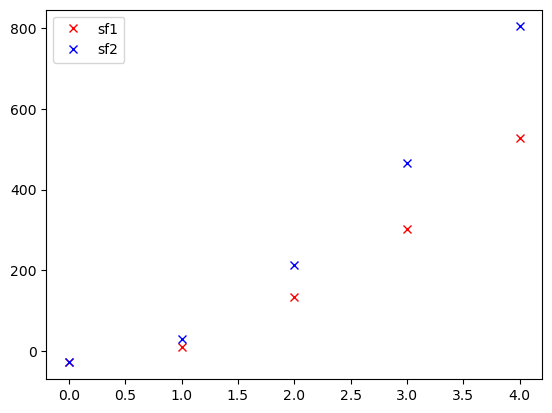

In [17]:
meV_a2_to_mJ_m2 = 16.021766
plt.plot(np.array(sf1)*meV_a2_to_mJ_m2,'rx', label="sf1")
plt.plot(np.array(sf2)*meV_a2_to_mJ_m2,'bx', label="sf2")
plt.legend()